# Instalación de librerias utilizadas

In [ ]:
!pip install pandas
!pip install sklearn
!pip install DateTime
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install xgboost
!pip install seaborn

In [361]:
import pandas as pd
import os
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from xgboost import XGBClassifier

# Lectura del archivo

* Se castearán las columnas con fechas a formato datetime para poder utilizar los atributos y funciones existentes en datetime.datetime y datetime.timedelta

# Parte 1,
* Distribución de los datos

In [478]:
data = pd.read_csv('dataset_SCL.csv', low_memory=False)
data['FI'] = pd.to_datetime(data['Fecha-I'])
data['FO'] = pd.to_datetime(data['Fecha-O'])
data['atraso'] = ((data['FI'] - data['FO']).dt.seconds >0).astype(int)
data = data.dropna() #Son muy pocos por lo que decidi sacar estos del data

<AxesSubplot:>

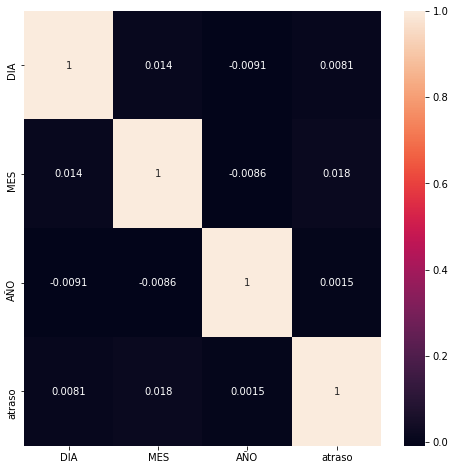

In [4]:
plt.figure(figsize = (8,8))
correlation_mat = data.corr()
sns.heatmap(correlation_mat, annot = True)

In [486]:
print(data['FI'].min(), data['FI'].max())
print(data['FO'].min(), data['FO'].max())

2017-01-01 00:15:00 2017-12-31 23:55:00
2017-01-01 00:04:00 2018-01-01 00:12:00


In [570]:
data.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,FI,FO,atraso
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,2017-01-01 23:30:00,2017-01-01 23:33:00,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,2017-01-02 23:30:00,2017-01-02 23:39:00,1


## Se prodecera a calcular la autocorrelacion de los minutos de atraso cada ocho horas.

* Se determino utilizar 8 horas de datos debido al horario laboral, se espera ver como afecta el tiempo de atraso total en autocorrelación de la serie con el fin de predecir maximos o minimos en el desfase entre el despegue programado y el horario real.

In [488]:
retraso_por_dia = pd.concat([data['FI'], (data['FO']-data['FI']).dt.seconds/60], axis = 1) # día del año
retraso_por_dia.columns = ['FI', 'atraso']
retraso_por_dia.sort_values(by = ['FI'])
mask = [data['FI'].min(), data['FI'].min() + timedelta(hours = 12)]
autocorrelacion = []
retraso_acumulado_normalizado = []
while mask[1]<= data['FO'].max():
    filter_data = retraso_por_dia.where((retraso_por_dia.FI >= mask[0]) & (retraso_por_dia.FI <= mask[1])).dropna()
    serie = pd.Series(filter_data['atraso'])
    autocorrelacion.append([serie.autocorr(1), serie.autocorr(2), serie.autocorr(3)])
    mask[0] = mask[0] + timedelta(hours = 8)
    mask[1] = mask[1] + timedelta(hours = 8)
    retraso_acumulado_normalizado.append([filter_data['atraso'].sum(), filter_data.shape[0]])
retraso_acumulado_normalizado = np.float32(retraso_acumulado_normalizado)
autocorrelacion = np.float32(autocorrelacion)

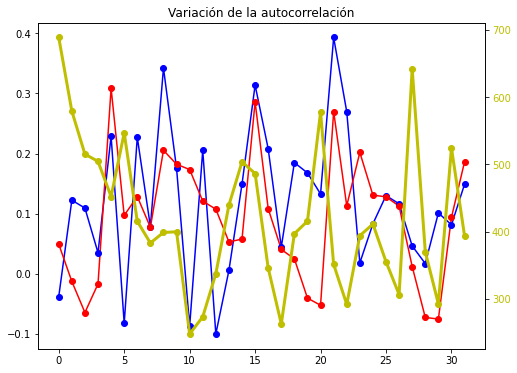

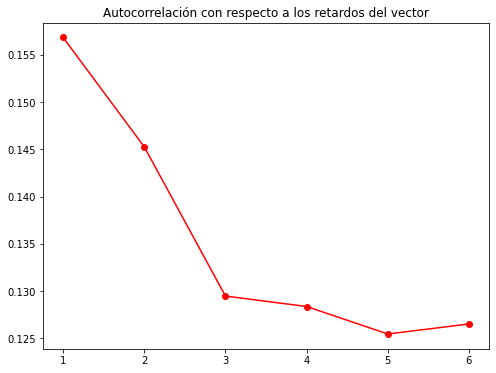

In [489]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_title('Variación de la autocorrelación')
ax1.plot(autocorrelacion[:32,0],'b')
ax1.plot(autocorrelacion[:32,1], 'r')
#ax1.plot(autocorrelacion[:32,2], 'g')

ax1.plot(autocorrelacion[:32,0],'bo')
ax1.plot(autocorrelacion[:32,1], 'ro')
#ax1.plot(autocorrelacion[:32,2], 'go')

ax2 = ax1.twinx()

ax2.plot(retraso_acumulado_normalizado[:32,0]/retraso_acumulado_normalizado[:32,1], c = 'y', linewidth=3.0)
ax2.plot(retraso_acumulado_normalizado[:32,0]/retraso_acumulado_normalizado[:32,1], 'yo')
ax2.tick_params(axis='y', labelcolor= 'y')

s = pd.Series(retraso_por_dia['atraso'])
correlacion = [s.autocorr(1), s.autocorr(2), s.autocorr(3), s.autocorr(4), s.autocorr(5),s.autocorr(6)]
plt.figure(figsize = (8,6))
plt.title('Autocorrelación con respecto a los retardos del vector')
plt.plot([1,2,3,4,5,6], correlacion,'r')
plt.plot([1,2,3,4,5,6], correlacion,'ro')

 La autocorrelación de la funcion para uno y dos retardos varia según el el horario, no se aprecia una relación entre el atraso total dividido en la cantidad de vuelos y correlación de la serie de tiempo de atraso en minutos.

 En el caso en que se quiera predecir la serie temporal se utilizara una red neuronal con el fin de generar un modelo no lineal con pesos dependientes a la entrada.

AndersonResult(statistic=15.273174372034362, critical_values=array([0.911, 1.066, 1.326, 1.588, 1.935]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


<ipython-input-490-13a97518b3b6>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  retraso_por_dia['semana'] = retraso_por_dia['FI'].dt.week


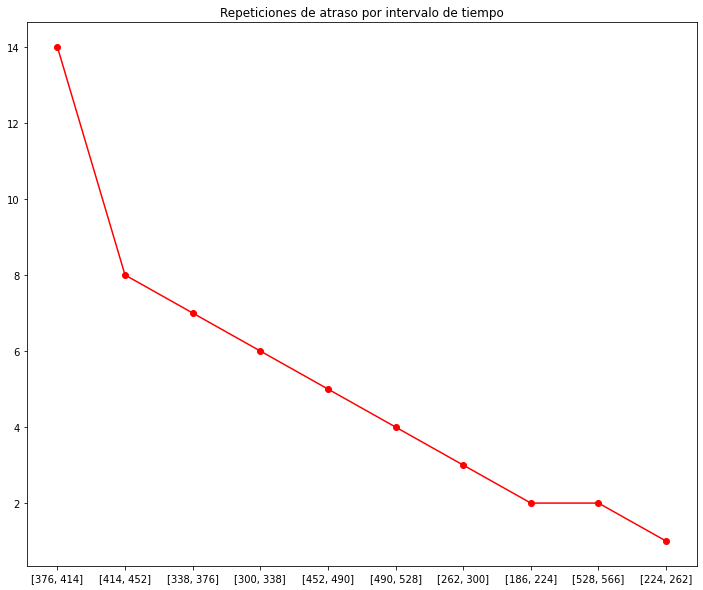

In [490]:
retraso_por_dia['semana'] = retraso_por_dia['FI'].dt.week
retraso_por_semana = retraso_por_dia.groupby('semana')['atraso'].sum()/retraso_por_dia['semana'].value_counts(sort = False)
k1,p_value = stats.normaltest(retraso_por_semana.values)

print(stats.anderson(retraso_por_semana.values, 'expon'))

aux = retraso_por_semana.value_counts(bins=10, sort=True)
indices = ['[376, 414]', '[414, 452]', '[338, 376]', '[300, 338]', '[452, 490]', '[490, 528]', '[262, 300]', '[186, 224]', '[528, 566]', '[224, 262]']
lam = np.round(np.mean(aux)**(-1), 4)#En una distribución exponencial el valor esperado es 1/lambda, 
                                     #Debido a que la media tiende al valor esperado considere utilizar esta para obtener el valor de lambda
plt.figure(figsize = (12, 10))
plt.title('Repeticiones de atraso por intervalo de tiempo')
plt.plot(indices, aux.values, 'ro')
plt.plot(indices, aux.values, 'r')

# Respuesta Parte 1,

* Gracias al Anderson-Darling test podemos decir con un nivel de significancia del 1%  que la suma de los atrasos semanales distribuyen exponencialmente.

* Debido a que la muestra distribuye exponencial se podria utilizar la distribución de Gumel para determinar los  maximos atrasos acumulados por temporada. Para realizar esto se requerirá una mayor cantidad de información anual por que para determinar los maximos por temporada se necesita el comportamiento historico de estos eventos.

* Cabe destacar que este análisis no sirve para años anómalos como este debido a que los cierres de fronteras y las restricciones de movimiento alteran significativamente la demanda de vuelos.

# Parte 2,
## A continuación se generarán las nuevas columnas requeridas.

In [480]:
data['temporada_alta'] = (((data['FI'].dt.month == 12)&(data['FI'].dt.day>=15))|(data['FI'].dt.month <= 2)|((data['FI'].dt.month == 3)&(data['FI'].dt.day<= 3))).astype(int)
data['temporada_alta'] = ((data['FI'].dt.month == 7)&((data['FI'].dt.day>=15)&(data['FI'].dt.day<=31))).astype(int) + data['temporada_alta']
data['temporada_alta'] = ((data['FI'].dt.month == 9)&((data['FI'].dt.day>=11)&(data['FI'].dt.day<=30))).astype(int) + data['temporada_alta']

data['dif_min'] = (data['FI'] - data['FO']).dt.seconds/60

data['atraso_15'] = (data['dif_min']>15).astype(int)

data.loc[(data['FI'].dt.hour>=5) & (data['FI'].dt.hour<12), ['periodo_dia']] = 'mañana'
data.loc[(data['FI'].dt.hour>=12) & (data['FI'].dt.hour<19), ['periodo_dia']] = 'tarde'
data.loc[(data['FI'].dt.hour>=19) | (data['FI'].dt.hour<5), ['periodo_dia']] = 'noche'

clean_data = pd.read_csv('dataset_SCL.csv', low_memory=False)
synthetic_features = pd.concat([clean_data, data['temporada_alta'], data['dif_min'], data['atraso_15'], data['periodo_dia']],axis = 1)
synthetic_features.to_csv('synthetic_features.csv')
clean_data = []
synthetic_features = []

# Parte 3,
* Para realizar un análisis de relación entre la tasa de atrasos y el resto de las variables presentes, se transformaran las variables categoricas a variables numericas.  De esta forma se podrán generar todo tipo de relaciones estadísticas y numéricas.

## Se procede a Transformar las variables categoricas a variables numericas 

* Para esto se utilizara la implementacion disponible en sklearn para transformar las aerolineas una base de vectores ortonormales entre ellos

In [214]:
def tasa_por_categoria(data, categoria_1, categoria_2):
    cantidad_total_vuelos = data.shape[0]
    aux = pd.concat([data[categoria_1], data[categoria_2]],axis = 1)
    aux[categoria_1] = (aux[categoria_1]>0).astype(int)
    atrasos =  aux[aux[categoria_1] == 1][categoria_2].value_counts()
    aux = pd.DataFrame((atrasos/cantidad_total_vuelos).reset_index())
    aux.columns = [categoria_2, 'Proporcion Total']
    return aux

def tasa_por_categoria_normalizada(data, categoria_2, S ='atraso'):
    groupdataA = data.groupby(categoria_2)[S].sum().sort_values().reset_index()
    groupdataV = data[categoria_2].value_counts().reset_index(name = 'cantidad de vuelos')
    mylist = groupdataV.columns.values
    mylist[0] = categoria_2
    groupdataV.columns = mylist

    mergedata = pd.merge(groupdataA, groupdataV, on = categoria_2, how = 'right')
    mergedata['Tasa'] = mergedata[S]/mergedata['cantidad de vuelos']
    mergedata = mergedata[[categoria_2,'Tasa']]
    return mergedata

In [221]:
tasa_por_Destino = tasa_por_categoria(data, 'dif_min', 'SIGLADES')
Tasa_por_Destino_normalizada = tasa_por_categoria_normalizada(data, 'SIGLADES')

tasa_por_Aerolinea = tasa_por_categoria(data, 'dif_min', 'OPERA')
Tasa_por_Aerolinea_normalizada = tasa_por_categoria_normalizada(data, 'OPERA')

tasa_por_MesdelAño = tasa_por_categoria(data, 'dif_min', 'MES')
tasa_por_MesdelAño_normalizada = tasa_por_categoria_normalizada(data,'MES' )

tasa_por_DiadelaSemana = tasa_por_categoria(data, 'dif_min', 'DIANOM')
tasa_por_DiadelaSemana_normalizada = tasa_por_categoria_normalizada(data, 'DIANOM')

tasa_por_Temporada = tasa_por_categoria(data, 'dif_min', 'temporada_alta')
tasa_por_Temporada_normalizada = tasa_por_categoria_normalizada(data, 'temporada_alta')

tasa_por_TipodeVuelo = tasa_por_categoria(data, 'dif_min', 'TIPOVUELO')
tasa_por_TipodeVuelo_normalizada = tasa_por_categoria_normalizada(data, 'TIPOVUELO')

## A contianuacion se concatenaran las tablas para visualizar de manera conjunta las tasas por categoria

In [217]:
pd.concat([tasa_por_Destino.head(12), Tasa_por_Destino_normalizada.head(12)],axis = 1)

,SIGLADES,Proporcion Total,SIGLADES,Tasa
0,Buenos Aires,0.088850,Buenos Aires,0.956590
1,Antofagasta,0.077941,Antofagasta,0.918769
2,Lima,0.072238,Lima,0.935092
3,Calama,0.068206,Calama,0.904003
4,Puerto Montt,0.058955,Puerto Montt,0.922883
5,Concepcion,0.053222,Concepcion,0.909091
6,Iquique,0.050509,Iquique,0.919402
7,Sao Paulo,0.049454,Sao Paulo,0.945083
8,Temuco,0.035115,Temuco,0.925068
9,La Serena,0.032652,Arica,0.908046


# Analisis de atrasos por destino

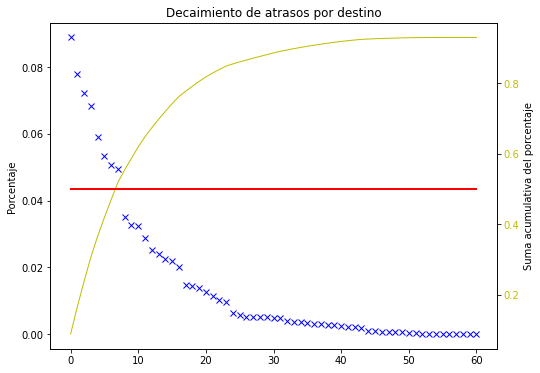

In [11]:
aux = pd.concat([tasa_por_Destino,tasa_por_Destino['Tasa'].cumsum().reset_index(name = 'suma acumulativa', drop = True)],axis = 1)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_title('Decaimiento de atrasos por destino')
ax1.plot(aux.iloc[:,1],'bx')
ax1.set_ylabel('Porcentaje')

ax2 = ax1.twinx()

ax2.plot(aux.iloc[:,2], linewidth=1.0, c = 'y')
ax2.plot(np.ones(aux.iloc[:,2].shape[0]) * 0.5, linewidth=2.0, c = 'r')
ax2.set_ylabel('Suma acumulativa del porcentaje')
ax2.tick_params(axis='y', labelcolor= 'y')

## La curva roja muestra el punto en que la suma acumulativa llega al 50% de la muestra total

* La tasa de atraso por destino decae exponencialmente y los vuelos  a Buenos Aires, Antofagasta, Lima, Calama, Puerto Montt, Concepcion e Iquique concentran el 50% de los atrasos totales.

*  Los vuelos con destino a las ciudades antes mencionadas tienen una tasa de atrasos mayor al 90%, además de aportar la mayor cantidad de vuelos con atrasos estos tienen una tasa de atraso muy cercana al 100%. 

# Analisis de atraso por aerolinea

In [203]:
pd.concat([tasa_por_Aerolinea, Tasa_por_Aerolinea_normalizada],axis = 1)

,OPERA,Proporcion Total,OPERA,Tasa
0,Grupo LATAM,0.556411,Grupo LATAM,0.928054
1,Sky Airline,0.193666,Sky Airline,0.923836
2,Aerolineas Argentinas,0.027315,Aerolineas Argentinas,0.955875
3,Copa Air,0.025321,Copa Air,0.933514
4,Latin American Wings,0.023151,Latin American Wings,0.943814
5,Avianca,0.015820,Avianca,0.936632
6,JetSmart SPA,0.014867,JetSmart SPA,0.926027
7,Gol Trans,0.011509,Gol Trans,0.973945
8,American Airlines,0.010322,American Airlines,0.929987
9,Air Canada,0.007932,Air Canada,0.957522


* En este punto surge un tema interesante, la aerolinea Grupo LATAM concentra más del 50% de los vuelos que presentan  atrasos, pero su tasa de vuelos con atrasos anual es superior al 90%. 

* Aunque el resto de las aerolineas presenten una menor cantidad de vuelos con atrasos, estas tambien tienen una tasa de vuelos con atraso superior al 90%. Se podría decir que todas la aerolineas presentan atrasos en sus vuelos en mas de un 90%

In [498]:
aux1 = data.groupby('OPERA')['atraso'].sum().reset_index()
aux2 = pd.DataFrame(data[['OPERA']].value_counts().reset_index())
aux2.columns = ['OPERA', 'cantidad vuelos']
aux3 = pd.merge(aux1, aux2, on ='OPERA', how = 'right')

aux3['Porcentaje de atrasos por aerolinea'] = aux3['atraso']/aux3['cantidad vuelos']
print (aux3['Porcentaje de atrasos por aerolinea'].mean())
aux3.sort_values(by = ['Porcentaje de atrasos por aerolinea'], ascending = False)

0.9380217205767702


,OPERA,atraso,cantidad vuelos,Porcentaje de atrasos por aerolinea
7,Gol Trans,785,806,0.973945
21,Austral,72,74,0.972973
19,Qantas Airways,189,195,0.969231
22,Plus Ultra Lineas Aereas,47,49,0.959184
12,Air France,343,358,0.958101
9,Air Canada,541,565,0.957522
2,Aerolineas Argentinas,1863,1949,0.955875
14,United Airlines,319,335,0.952239
17,K.L.M.,239,251,0.952191
16,Alitalia,245,259,0.945946


* De la tabla anterior se determina que la diferencia entre la aerolinea que presenta la mayor tasa de atrasos y la aeorlinea que presenta la menor hay una diferencia de un 10% aproximadamente.  Es decir, las aerolineas presentan una tasa de atrasos, con respecto a su cantidad de vuelos totales, similar. 

* El promedio de la cantidad de vuelos con atraso por aerolinea es de un 93.80%.


# Analisis por mes del año, día de la semana, tipo de vuelo y temporada

In [224]:
pd.concat([tasa_por_MesdelAño,tasa_por_MesdelAño_normalizada],axis = 1)

,MES,Proporcion Total,MES,Tasa
0,12,0.087442,12,0.938326
1,1,0.083484,1,0.932373
2,10,0.083469,11,0.934046
3,11,0.083264,10,0.943800
4,7,0.082692,7,0.941255
5,8,0.077428,8,0.919394
6,9,0.076490,9,0.929947
7,2,0.075977,2,0.931847
8,3,0.073822,3,0.918460
9,5,0.070713,5,0.920420


In [225]:
pd.concat([tasa_por_DiadelaSemana,tasa_por_DiadelaSemana_normalizada],axis = 1)

,DIANOM,Proporcion Total,DIANOM,Tasa
0,Viernes,0.141368,Viernes,0.936844
1,Jueves,0.140048,Jueves,0.931902
2,Lunes,0.137952,Lunes,0.928734
3,Domingo,0.133084,Domingo,0.926603
4,Miercoles,0.132292,Miercoles,0.928101
5,Martes,0.130592,Martes,0.921859
6,Sabado,0.114449,Sabado,0.934626


In [226]:
pd.concat([tasa_por_Temporada, tasa_por_Temporada_normalizada],axis = 1)

,temporada_alta,Proporcion Total,temporada_alta,Tasa
0,0,0.617506,0,0.926789
1,1,0.312279,1,0.935767


In [227]:
pd.concat([tasa_por_TipodeVuelo, tasa_por_TipodeVuelo_normalizada],axis = 1)

,TIPOVUELO,Proporcion Total,TIPOVUELO,Tasa
0,N,0.496899,N,0.916815
1,I,0.432886,I,0.945133


* La tasa de atrasos por mes es muy similar entre cada mes del año. Aun que la cantidad de vuelos por mes sea distinta la tasa de atrasos por mes es muy similar, estas se mueven entre el 94 y el 90 porciento. 

* Ocurre algo similar con respecto a la tasa de atrasos por día. La diferencia de estos no es relevante devido a que la diferencia entre el máximo y mínimo ronda el 1%. Basta con determinar si la cantidad de vuelos se concentra para ciertos días durante todo el año o varia según el intervalo de tiempo a escoger

* La concentración de atrasos en temporada baja se debe en gran medida a que en la temporada baja se tiene una mayor cantidad de días debido a la duración de esta. Ambas tasas estan muy cercanas aun que se presentan una mayor tasa de atraso para la temporada alta.


In [228]:
mask_1 = mask = [data['FI'].min(), data['FI'].min() + timedelta(hours = 1440)]# aproximadamente 4 meses de datos
mask_2 = mask = [data['FI'].min() + timedelta(hours = 1440), data['FI'].min() + timedelta(hours = 2880)]# aproximadamente 2 meses de datos
mask_3 = mask = [data['FI'].min() + timedelta(hours = 2880), data['FI'].min() + timedelta(hours = 4320)]# aproximadamente 2 meses de datos desde marzo
mask_4 = mask = [data['FI'].min() + timedelta(hours = 4320), data['FI'].min() + timedelta(hours = 4320*2)]# aproximadamente 2 meses de datos desde mayo

G1 = tasa_por_categoria(data[(data['FI']>=mask_1[0]) & (data['FI']<=mask_1[1])], 'dif_min', 'DIANOM')
G2 = tasa_por_categoria(data[(data['FI']>=mask_2[0]) & (data['FI']<=mask_2[1])], 'dif_min', 'DIANOM')
G3 = tasa_por_categoria(data[(data['FI']>=mask_3[0]) & (data['FI']<=mask_3[1])], 'dif_min', 'DIANOM')
G4 = tasa_por_categoria(data[(data['FI']>=mask_4[0]) & (data['FI']<=mask_4[1])], 'dif_min', 'DIANOM')

pd.concat([G1,G2,G3,G4], axis = 1)

,DIANOM,Proporcion Total,DIANOM,Proporcion Total,DIANOM,Proporcion Total,DIANOM,Proporcion Total
0,Lunes,0.145122,Viernes,0.144714,Jueves,0.150528,Viernes,0.145845
1,Miercoles,0.141749,Jueves,0.143356,Lunes,0.146145,Lunes,0.140130
2,Domingo,0.138798,Domingo,0.137827,Martes,0.142359,Jueves,0.138702
3,Martes,0.134666,Lunes,0.127546,Miercoles,0.134290,Martes,0.132587
4,Viernes,0.129606,Miercoles,0.122308,Viernes,0.129607,Domingo,0.132358
5,Jueves,0.126739,Martes,0.120369,Domingo,0.121538,Miercoles,0.129529
6,Sabado,0.115693,Sabado,0.116004,Sabado,0.102610,Sabado,0.115642


* En la tabla anterior se puede apreciar que el unico día que se mantiene con una tasa de atrasos es el día sabado y además corresponde al dia con la menor tasa de vuelos con atraso. independiente de la ventana de tiempo el día sabado presenta menor cantidad de vuelos.


# Respuesta Parte 3,

* Considero que una variable importante para determinar si un vuelo presentara un atraso en su despegue es el porcentaje de vuelos que estan saliendo atrasados actualmente. Considero que esta es una variable importante debido a que todos los aviones comparten la pista y el atraso de un vuelo podria gatillar el atraso de un conjunto elevado de aviones.

(0.0, 143.42)

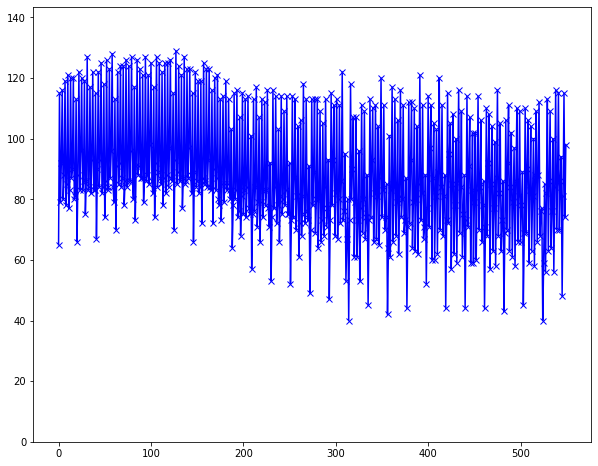

In [502]:
plt.figure(figsize =(10,8))
plt.plot(retraso_acumulado_normalizado[:550,1],'b')
plt.plot(retraso_acumulado_normalizado[:550,1],'bx')
plt.ylim((0,max(retraso_acumulado_normalizado[:,1])*1.01))

* A simple vista resalta una gran variabilidad del tiempo de atraso normalizado con respecto a la cantidad de vuelos totales en un rango de tiempo (8 horas).  Se podria llegar a hacer un analisis en series de tiempo para los candidatos que tengan una alta probabilidad de presentar un atraso en su hora pre definida de despege.

# Parte 4,

* Se procede a Transformar las variables categoricas a variables numericas. Para realizar esto se utilizara la implementacion disponible en sklearn para transformar las aerolineas una base de vectores ortonormales entre ellos

* El DataFrame data_encoder se utilizara para entrenar un método que entregue la probabilidad que tiene un vuelo en presentar atraso.

In [234]:
def vectorizar(data, categoria):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc = pd.DataFrame(enc.fit_transform(data[[categoria]]).toarray())
    union = data[[categoria]].join(enc)
    columnas = []
    for i in range(1, union.shape[1]):
        columnas.append(union[union.iloc[:,i] == 1].iloc[0,0])
    enc.columns = columnas
    return enc

In [537]:
enc_SiglasCiudad = vectorizar(data, 'SIGLADES')
enc_MES = vectorizar(data, 'MES')
enc_PeriodoDia = vectorizar(data, 'periodo_dia')
enc_TIPOVUELO = vectorizar(data, 'TIPOVUELO')
enc_OPERA = vectorizar(data, 'OPERA')

data_encoder = (pd.concat([data['atraso'], data['temporada_alta'], enc_PeriodoDia, enc_OPERA, enc_TipoVuelo, enc_SiglasCiudad, enc_MES], axis = 1)).dropna()
data_encoder.head()

,atraso,temporada_alta,mañana,noche,tarde,Aerolineas Argentinas,Aeromexico,Air Canada,Air France,Alitalia,...,2,3,4,5,6,7,8,9,10,11
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [507]:
DcA = data_encoder.where(data_encoder.atraso == 1).dropna() # Vuelos con retraso en el despege
DsA = data_encoder.where(data_encoder.atraso == 0).dropna() # Vuelos sin retraso en el despege

### Conjunto de entrenamiento y testeo para vuelos sin atraso

In [508]:
size_TrainData = int(DsA.shape[0]*.9)

aux = DsA.where(DsA.I ==1).dropna()
auxx = DsA.where(DsA.N ==1).dropna()

Xtr1 = pd.concat([aux.iloc[:int(size_TrainData*.5),:], auxx.iloc[:int(size_TrainData*.5),:]])
Xte1 = pd.concat([aux.iloc[int(size_TrainData*.5):,:], auxx.iloc[int(size_TrainData*.5):int(size_TrainData*.5)*2,:]])


### Conjunto de entrenamiento y testeo para vuelos con atraso

In [509]:
size_TrainData = int(DsA.shape[0]*.9)

aux = DcA.where(DcA.I ==1).dropna()
auxx = DcA.where(DcA.N ==1).dropna()

Xtr2 = pd.concat([aux.iloc[:int(size_TrainData*.5),:], auxx.iloc[:int(size_TrainData*.5),:]])
Xte2 = pd.concat([aux.iloc[int(size_TrainData*.5):int(size_TrainData*.5)*2,:], auxx.iloc[int(size_TrainData*.5):int(size_TrainData*.5)*2,:]])


In [511]:
A = pd.concat([Xtr1, Xtr2]).sample(frac = 1)
X_train = A.iloc[:,1:]
y_train = A.iloc[:,0]

B = pd.concat([Xte1, Xte2]).sample(frac = 1)
X_test = B.iloc[:,1:]
y_test = B.iloc[:,0]

# Modelos

* La primera opción que se implementara es el método de los vecinos mas cercanos. Debido a que se tienen una gran cantidad de variables para este método se utilizara el método de reducción de variables PCA con el fin de obtener la mejor metrica posible.


In [550]:
random_state = 0
knn = KNeighborsClassifier(n_neighbors = 600)

pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))
pca.fit(X_train, y_train)

knn.fit(pca.transform(X_train), y_train)
print('precisión entrenamient: ' + str(np.round(100*knn.score(pca.transform(X_train), y_train),2)))
acc_knn = knn.score(pca.transform(X_test), y_test)
print('precisión testeo: ' + str(np.round(100*acc_knn,2)))

precisión entrenamient: 91.93
precisión testeo: 81.39


precisión en el conjunto de entrenamiento: 91.494%
precisión en el conjunto de testeo: 78.343%


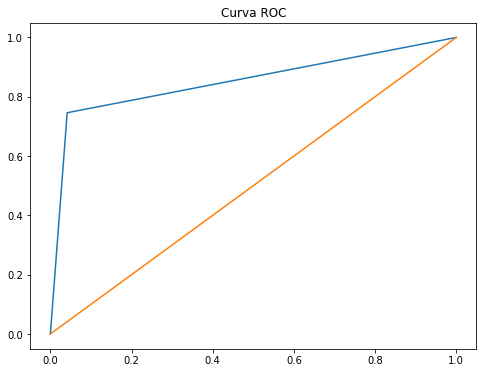

In [544]:
pcab = make_pipeline(StandardScaler(), PCA(n_components= 2, random_state = 0))
pcab.fit(X_train, y_train)

bnb = BernoulliNB()
bnb.fit(pcab.transform(X_train), y_train)
print('precisión en el conjunto de entrenamiento: ' + str(np.round(bnb.score(pcab.transform(X_train), y_train)*100,3))+'%')
print('precisión en el conjunto de testeo: ' + str(np.round(bnb.score(pcab.transform(X_test), y_test)*100,3))+'%')

y_pred_proba = bnb.predict(pcab.transform(X_test))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize = (8,6))
plt.title('Curva ROC')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr,fpr)

92.899%
66.903%


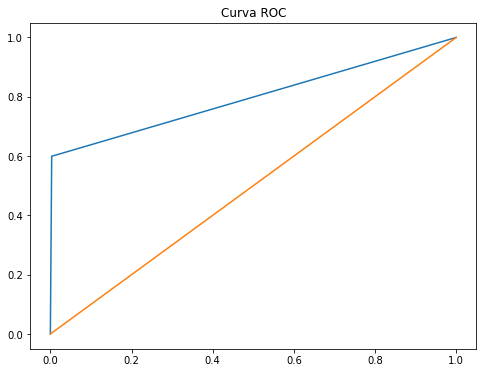

In [482]:
pcag = make_pipeline(StandardScaler(), PCA(n_components= 4, random_state = 0))
pcag.fit(X_train, y_train)

gnb = GaussianNB()
gnb.fit(pcag.transform(X_train), y_train.values)

print('precisión en el conjunto de entrenamiento: ' + str(np.round(gnb.score(pcag.transform(X_train), y_train)*100,3))+'%')
print('precisión en el conjunto de testeo: ' + str(np.round(gnb.score(pcag.transform(X_test), y_test)*100,3))+'%')

y_pred_proba = gnb.predict(pcag.transform(X_test))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize = (8,6))
plt.title('Curva ROC')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr,fpr)

precisión en el conjunto de entrenamiento: 94.79344903446591
precisión en el conjunto de testeo: 46.030227664052035


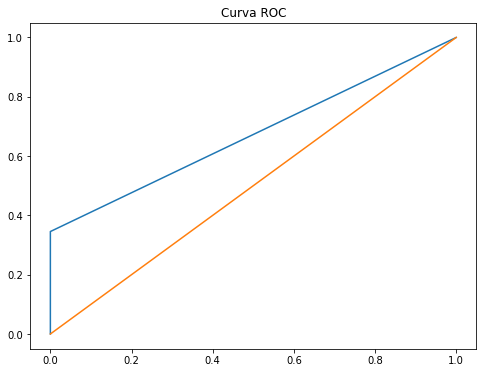

In [551]:
pcax = make_pipeline(StandardScaler(), PCA(n_components= 2, random_state=random_state))
pcax.fit(X_train, y_train)

modelXGB = XGBClassifier(use_label_encoder=False, objective='binary:logistic', n_estimators= 4)
modelXGB.fit(pca.transform(X_train), y_train.values, eval_metric= 'rmsle')

print('precisión en el conjunto de entrenamiento: ' + str(modelXGB.score(pca.transform(X_train.values), y_train.values)*100))
print('precisión en el conjunto de testeo: ' + str(modelXGB.score(pca.transform(X_test.values), y_test.values)*100))

y_pred_proba = modelXGB.predict(pcax.transform(X_test))
fpr, tpr, _ = metrics.roc_curve(y_test.values,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize = (8,6))
plt.title('Curva ROC')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr,fpr) #Y = X, necesaria para determinar si la curva roc esta sobre esta para ver que tal esta prediciendo

In [542]:
probabildiad_de_atraso = bnb.predict_proba(pcab.transform(data_encoder.iloc[:,1:]))[:,1]
data.loc[data_encoder.index, 'probabilidad de atraso'] = probabildiad_de_atraso
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,SIGLAORI,SIGLADES,FI,FO,atraso,temporada_alta,dif_min,atraso_15,periodo_dia,probabilidad de atraso
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Santiago,Miami,2017-01-01 23:30:00,2017-01-01 23:33:00,1,1,1437.0,1,noche,0.875119
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Santiago,Miami,2017-01-02 23:30:00,2017-01-02 23:39:00,1,1,1431.0,1,noche,0.875119
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Santiago,Miami,2017-01-03 23:30:00,2017-01-03 23:39:00,1,1,1431.0,1,noche,0.875119
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Santiago,Miami,2017-01-04 23:30:00,2017-01-04 23:33:00,1,1,1437.0,1,noche,0.875119
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Santiago,Miami,2017-01-05 23:30:00,2017-01-05 23:28:00,1,1,2.0,0,noche,0.875119


* Se escogieron estos métodos debido a que el objetivo del defasío es determinar la probabilidad de que un vuelo presente atrasos. 


* El arból de desición boosteado fue utilizado para contrastar las metricas de los métodos probabilisticos con un método ampliamente usado en los desafíos de Kaggle


* Debido a que tenemos una gran cantidad de parametros se procesio a utilizar el algoritmo reductos de varibles PCA. Debido a que la correlacion entre la variable objetivo y el resto (sin vectorizar) no eradeterminante se decidio vectorizar todas las variables categoricas y luego reducir el numero de variables de entrada al número que maximizara la metrica de accurracy de los modelos clasificadores.


* El array probabilidad de atraso contiene la probabilidad de que un vuelo salga atrasado del aéropuerto


* La mejor precisión se obtuvo con el knn, este método sirve para clasificar los vuelos antes de que el avión abandone el aeropuerto. Este modelo no sirve para calcular probabilidad de que un avión salga con atraso pero es muy bueno para clasificarlos con atraso y no atraso.


* Debido a que utilice un método reducor de variables no puedo determinar cual de las variables de entrada influyó en mayor medida. La cantidad de variables finales se determino euristicamente según como mejoraba la precisión del modelo.


* Quedo pendiente la prediccion de atraso por vuelo y ocupar la tasa de atraso de las ocho horas anteriores para calcular la probabilidad de que los vuelos de las siguientes ocho horas presente atrasos.